## Raw Data Analysis

For the analysis discussed on 12/04/24

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
choiceTextFile = 'For Kunal - Choic text CAF v0.1_April 11, 2024_23.09.xlsx'
numericValueFile = 'For Kunal - Numeric values CAF v0.1_April 11, 2024_23.09 2.xlsx'
choiceTextDf = pd.read_excel(choiceTextFile)
numericValueDf = pd.read_excel(numericValueFile)

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
headerKeyChoiceText = dict(zip(choiceTextDf.columns, choiceTextDf.iloc[0]))
choiceTextDf['FullName'] = choiceTextDf['RecipientFirstName'] + ' ' + choiceTextDf['RecipientLastName']
# choiceTextDf.drop(index=choiceTextDf.index[0], axis=0, inplace=True)
# choiceTextDf.dropna(axis=1, how='all', inplace=True)
# choiceTextDf.head()
# for choiceTextColumn in choiceTextDf.columns:
#     print(f'{choiceTextColumn}:  {headerKeyChoiceText[choiceTextColumn]}') 

### Extract ORAL20005

In [3]:
oral20005df = choiceTextDf[choiceTextDf['Q8'] == 'ORAL20005']
print(oral20005df.shape)
# oral20005df.head()
# oral20005df[(oral20005df['Q3'] == 'Paloma') | (oral20005df['Q4'] == 'Paloma')]
# oral20005df[oral20005df.isin(['ORAL20005']).any(axis=1)]

(1217, 1267)


### Extract ORAL30002

Extract Info about Students

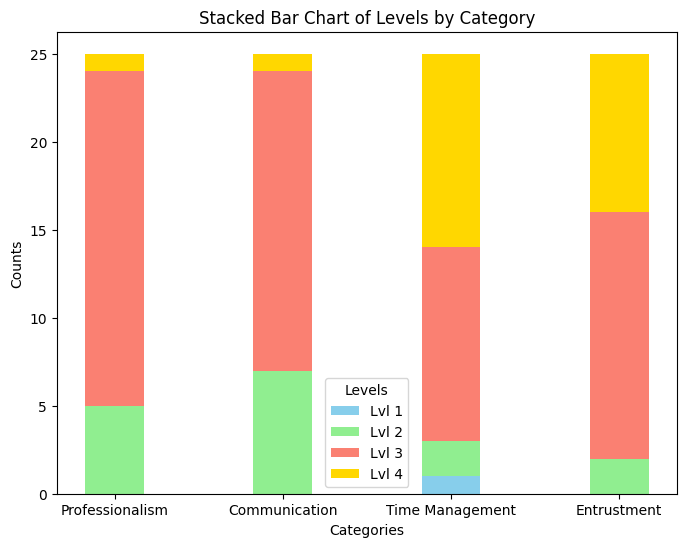

In [4]:
import numpy as np
oral30002df = choiceTextDf[choiceTextDf['Q8'] == 'ORAL30002']
# Remove rows where 'RecipientFirstName' or 'RecipientLastName' are NaN or empty
oral30002df = oral30002df[
    oral30002df['RecipientFirstName'].notna() & oral30002df['RecipientFirstName'].str.strip().ne('') &
    oral30002df['RecipientLastName'].notna() & oral30002df['RecipientLastName'].str.strip().ne('')
]
saveFolder = 'oral30002/studentReport'

def createPieChart(ax, data, title, xlabel, ylabel):
    """
    Creates a pie chart on the specified axes.

    Args:
    ax (matplotlib.axes.Axes): The axes object to plot on.
    data (pandas.Series): The data to plot.
    title (str): Title of the subplot.
    """
        # Custom autopct function to show both percentage and count
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(p=pct, v=val)
        return my_autopct
    
    counts = data.value_counts()
    cmap = plt.get_cmap('tab20')  # A colormap with 20 distinct colors
    colors = [cmap(i) for i in range(len(counts))]
    ax.pie(counts, labels=counts.index, autopct=make_autopct(counts.values), startangle=90, colors=colors)
    ax.set_title(title)
    total = counts.sum()  # Calculate the total sum of the counts
    ax.text(0.95, 0.95, 'Total: {}'.format(total), transform=ax.transAxes,
            horizontalalignment='right', verticalalignment='top', fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    # Adding a circle at the center to turn pie into a donut chart
    # circle = plt.Circle((0,0), 0.7, color='white')
    # ax.add_artist(circle)
    return counts

def createBarChart(ax, data, title, xlabel, ylabel):
    """
    Creates a bar chart on the specified axes.

    Args:
    ax (matplotlib.axes.Axes): The axes object to plot on.
    data (pandas.Series): The data to plot.
    title (str): Title of the subplot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    """
    counts = data.value_counts()
    counts.index = counts.index.astype(str)
    ax.bar(counts.index, counts.values, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, counts.max() + 5)
    total = counts.sum()  # Calculate the total sum of the counts
    ax.text(0.95, 0.95, 'Total: {}'.format(total), transform=ax.transAxes,
            horizontalalignment='right', verticalalignment='top', fontsize=12, color='black',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    # ax.grid(axis='y', linestyle='--', alpha=0.6)
    return counts

def plotGraphs(personName, data):
    data = data.dropna(axis=1, how='all')
    # print(data.describe())
    data.head()

    data.drop(['RecipientFirstName', 'RecipientLastName', 'Status', 'IPAddress', "RecordedDate", "ResponseId",
                    'RecipientEmail', 'LocationLatitude',	'LocationLongitude', 'DistributionChannel', 'UserLanguage'], axis=1, inplace=True)
    data.drop(['Q2', 'Q3', 'Q4',	'Q5',	'Q6',	'Q7',	'Q12',	'Q132'], axis=1, inplace=True)
    data['StartDate'] = pd.to_datetime(data['StartDate'])
    data['EndDate'] = pd.to_datetime(data['EndDate'])
    data['Date'] = data['StartDate'].dt.date
    # data['Duration'] = (data['EndDate'] - data['StartDate']).dt.total_seconds()
    data.head(3)

    fig, axarr = plt.subplots(2, 3, figsize=(18, 12))
    
    # Progress
    createBarChart(axarr[0, 0], data['Progress'], 'Progress Distribution', 'Progress', 'Count')
    
    # Finished
    counts = createBarChart(axarr[0, 1], data['Finished'], 'Finished Distribution', 'Finished', 'Count')
    # print(f'%age finished: {counts["True"]}/{counts.sum()} = {counts["True"] / counts.sum() * 100:.2f}%')

    # Critical incidents
    criticalI = data["Q59"].value_counts().reindex(['Yes', 'No'], fill_value=0)
    if criticalI["Yes"] > 0:
        print(f'\n********{personName}*******')
        print(f'Number of Critical incidents:\nYes - {criticalI["Yes"]}\nNo - {criticalI["No"]}')

    # Professionalism scale
    data["Q61"] = data["Q61"].str.extract('(Lvl \d)')
    createBarChart(axarr[0, 2], data["Q61"], 'Professionalism Scale', 'Professionalism Level', 'Count')
    
    # Communication scale
    data["Q62"] = data["Q62"].str.extract('(Lvl \d)')
    createBarChart(axarr[1, 0], data["Q62"], 'Communication Scale', 'Communication Level', 'Count')

    # Time management scale
    data["Q130"] = data["Q130"].str.extract('(Lvl \d)')
    createBarChart(axarr[1, 1], data["Q130"], 'Time Management Scale', 'Time Management Level', 'Count')

    # Entrustment scale
    data["Q63"] = data["Q63"].str.extract('(Lvl \d)')
    createBarChart(axarr[1, 2], data["Q63"], 'Entrustment Scale', 'Entrustment Level', 'Count')

    fig.suptitle(f'{personName}', fontsize=16, y=0.95)
    plt.savefig(f'{saveFolder}/{personName}.png')
    plt.close(fig)


    for col in ['Q61', 'Q62', 'Q130', 'Q63']:
        data[col] = data[col].str.extract('(Lvl \d)')

    # List of question columns and their corresponding names
    questions = ['Q61', 'Q62', 'Q130', 'Q63']
    categories = ['Professionalism', 'Communication', 'Time Management', 'Entrustment']

    # Aggregate data by level within each category
    level_data = {}
    for question, category in zip(questions, categories):
        level_data[category] = data[question].value_counts().reindex(['Lvl 1', 'Lvl 2', 'Lvl 3', 'Lvl 4'], fill_value=0)

    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Colors for each level (adjust or add more as needed)
    colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

    # X locations for the groups
    x = np.arange(len(categories))

    # Generate bars for each level
    width = 0.35  # Bar width
    for i, level in enumerate(['Lvl 1', 'Lvl 2', 'Lvl 3', "Lvl 4"]):
        values = [level_data[cat][level] for cat in categories]
        if i == 0:
            ax.bar(x, values, width, label=level, color=colors[i])
        else:
            # Calculate bottom values for stacking
            bottoms = [sum([level_data[cat][lvl] for lvl in ['Lvl 1', 'Lvl 2', 'Lvl 3', 'Lvl 4'][:i]]) for cat in categories]
            ax.bar(x, values, width, bottom=bottoms, label=level, color=colors[i])

    # Add labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Categories')
    ax.set_ylabel('Counts')
    ax.set_title('Stacked Bar Chart of Levels by Category')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend(title='Levels')


    # Save and close the figure
    # fig.savefig('stacked_bar_chart.png')
    # plt.close(fig)
    
def extractPersonInfo(personName, choiceTextDf):
    # print(f'\n********{personName}*******')
    data = choiceTextDf[choiceTextDf['FullName'] == personName]
    plotGraphs(personName, data)
    # print(data)
    # print(data.describe())
    
extractPersonInfo('Paloma Araos-West', oral30002df)
# extractPersonInfo('Zephaniah Josephene', oral30002df)
# extractPersonInfo('Thuvasaki Mahinthan', oral30002df)

For all students extract info

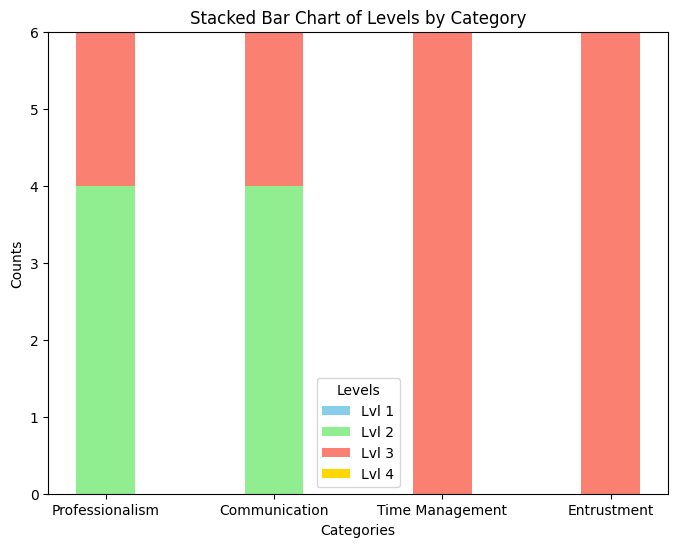

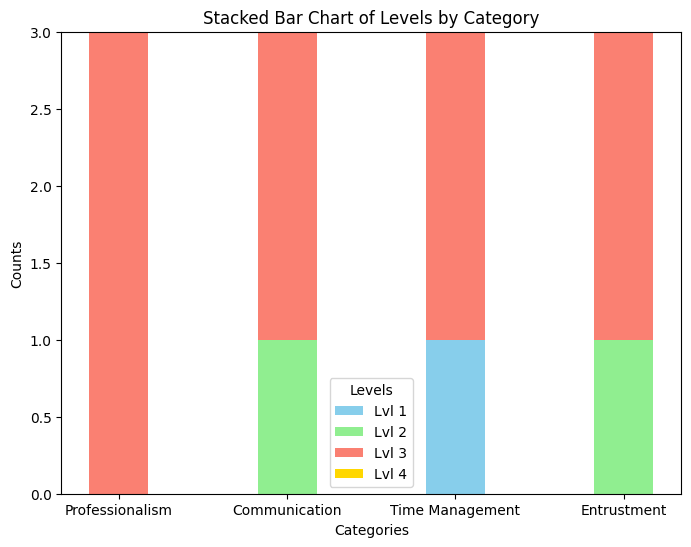

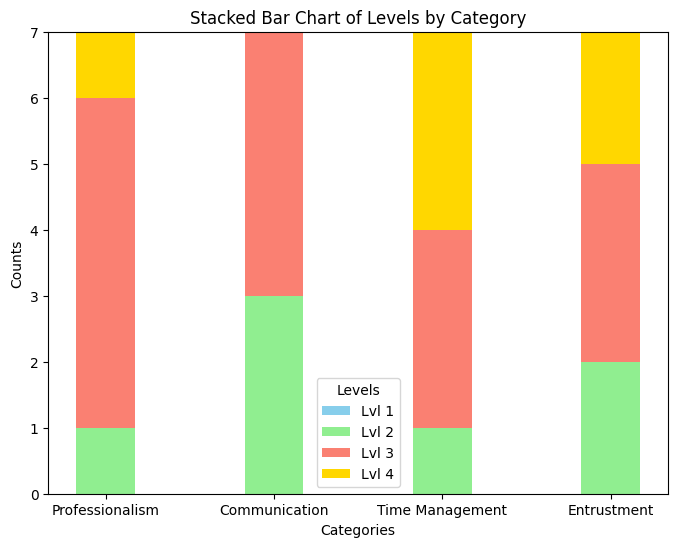

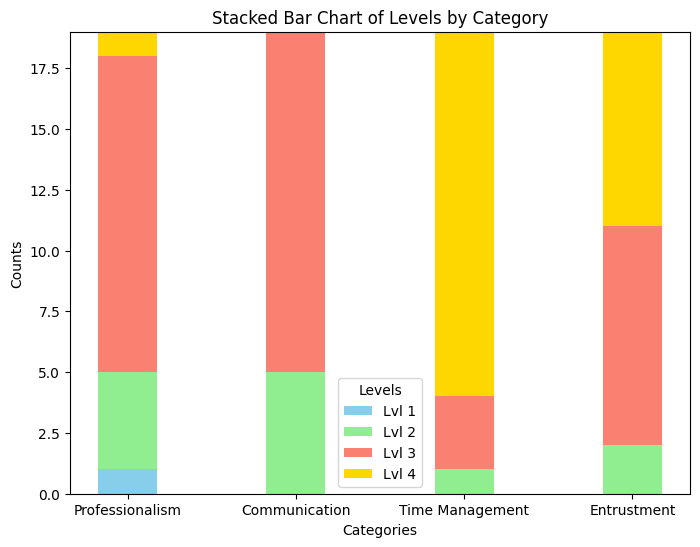

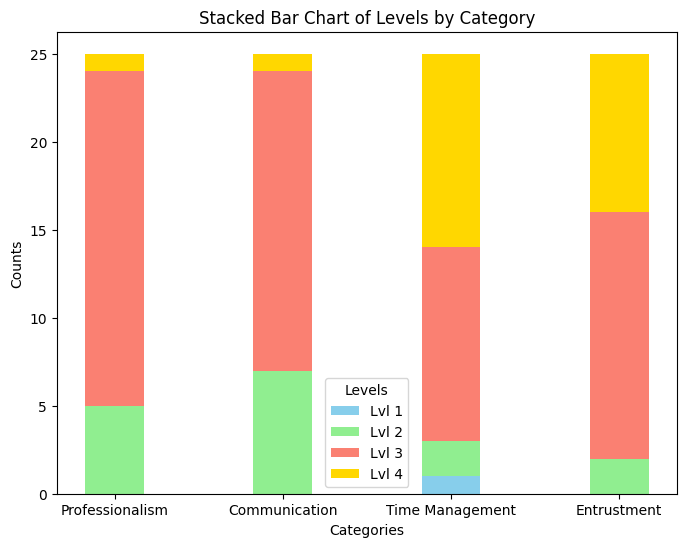

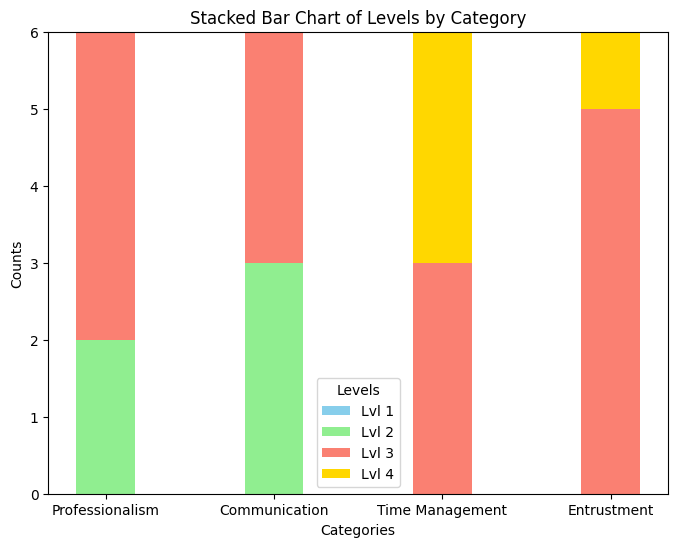

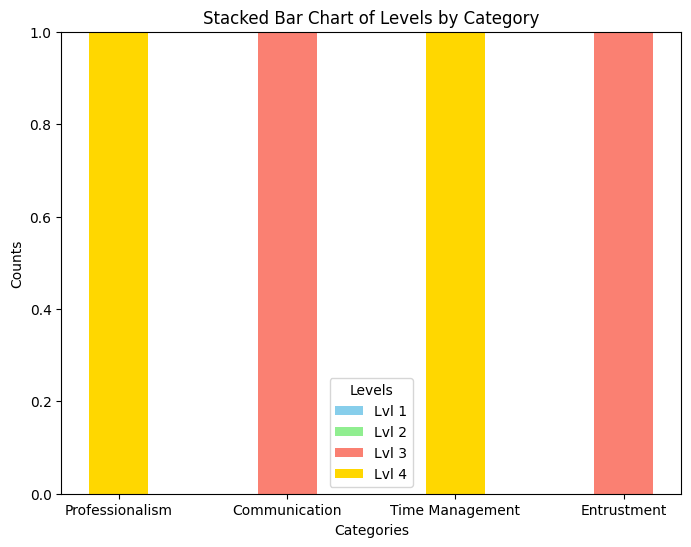

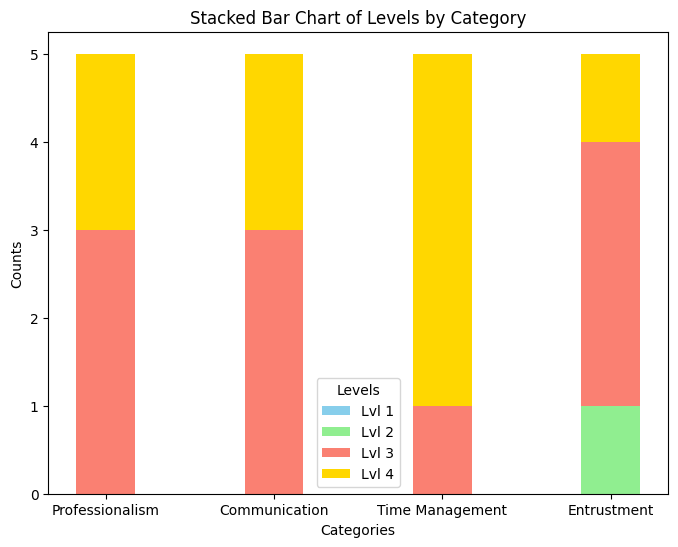

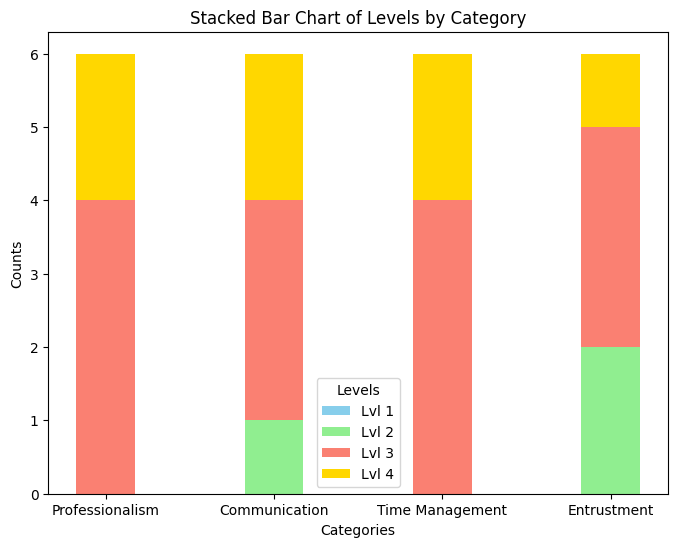

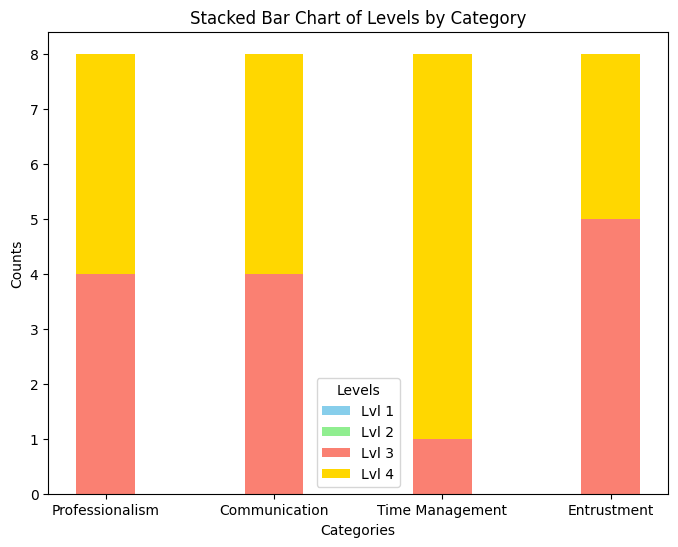

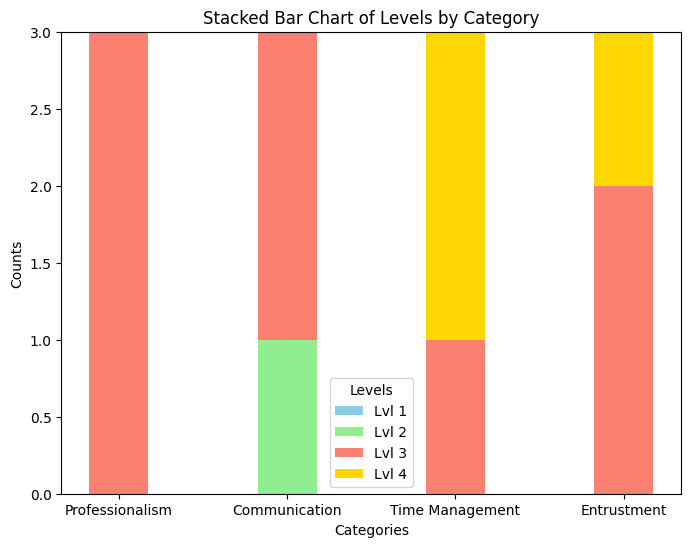

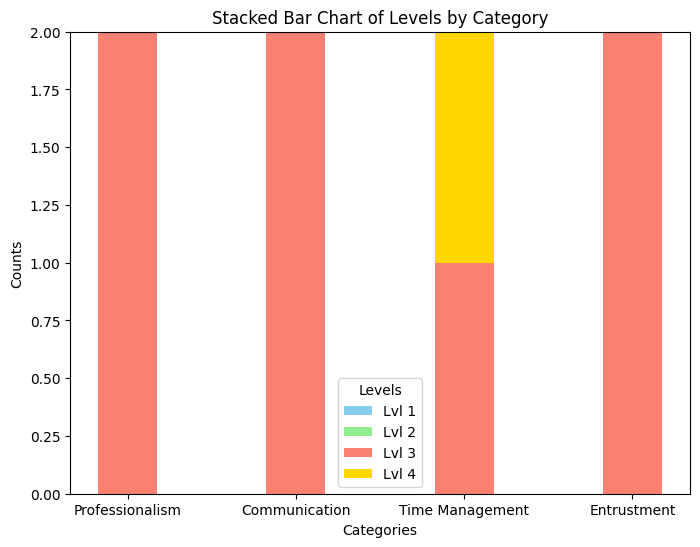

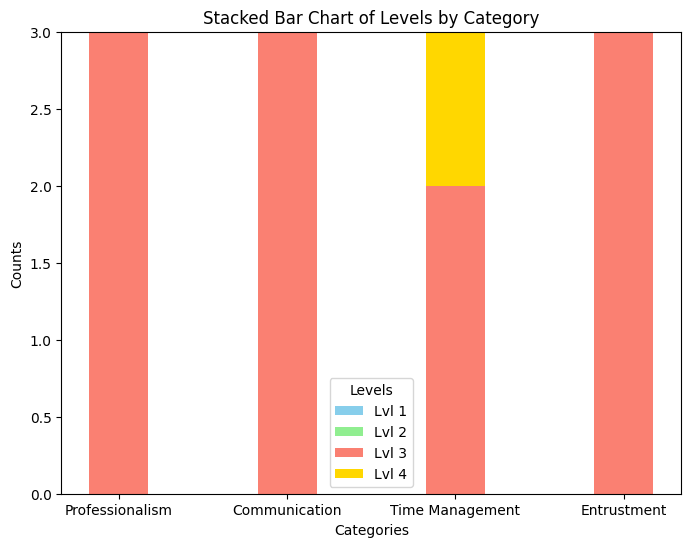

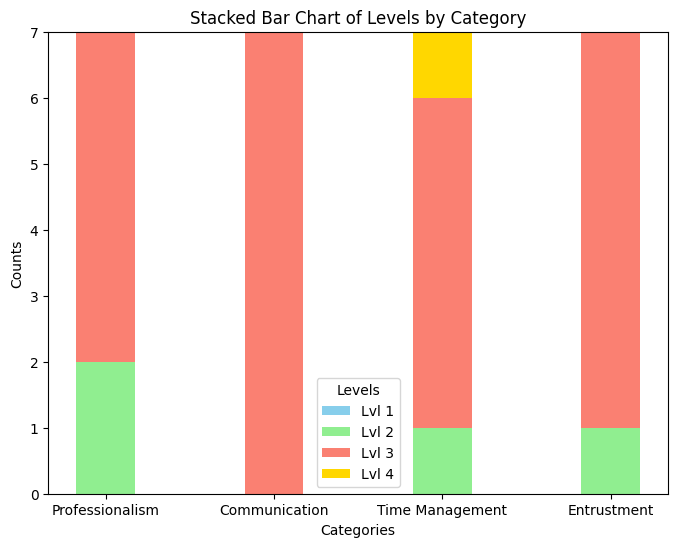

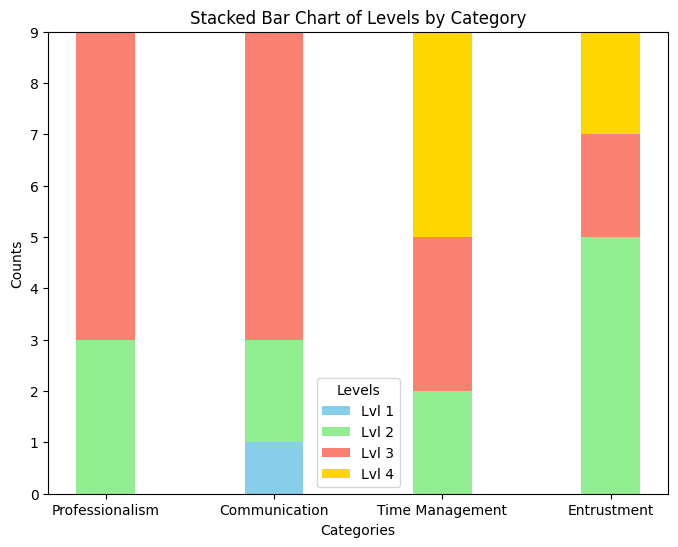

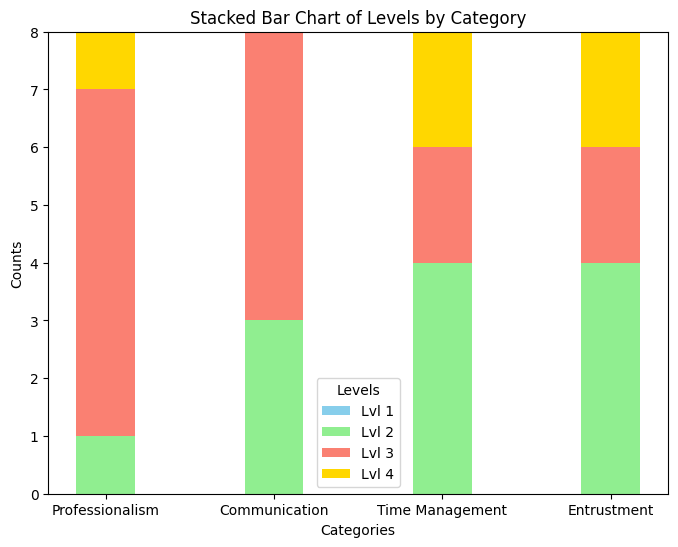

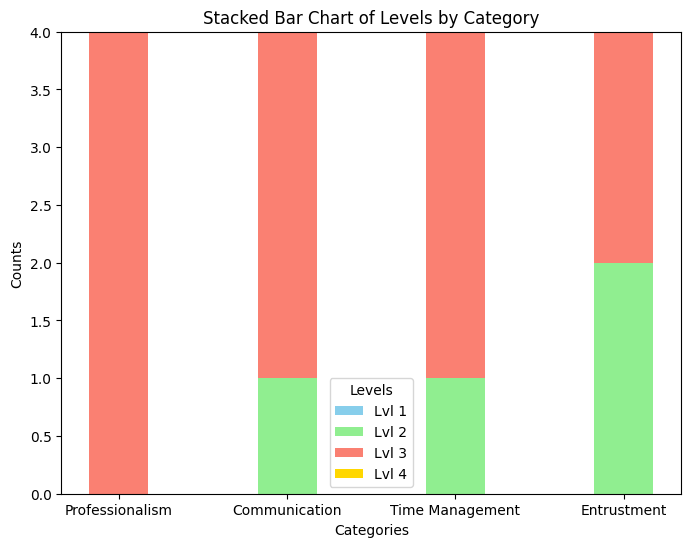

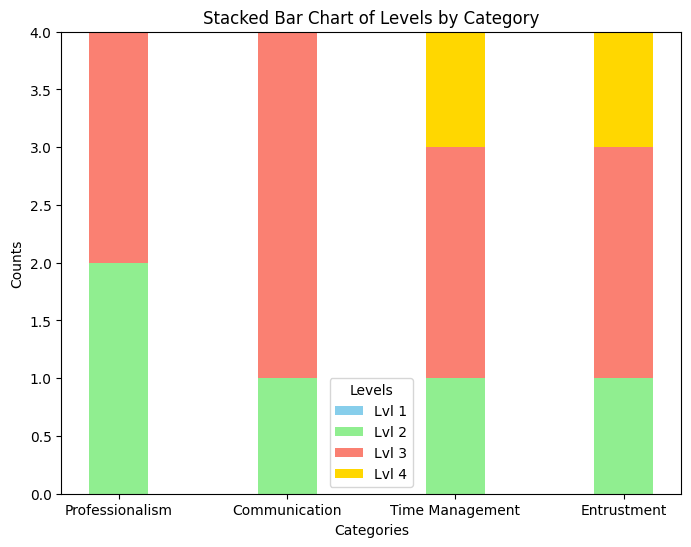

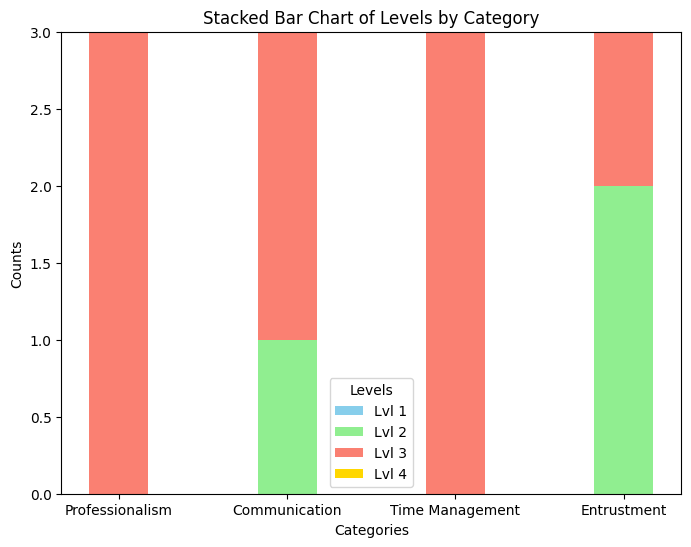

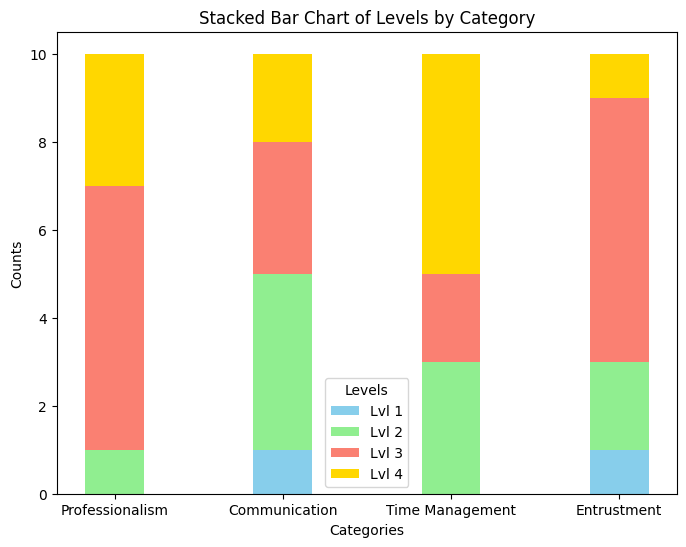

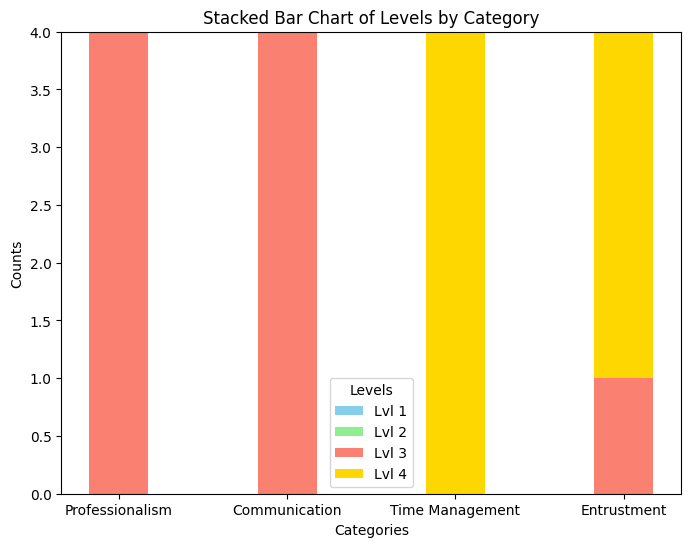

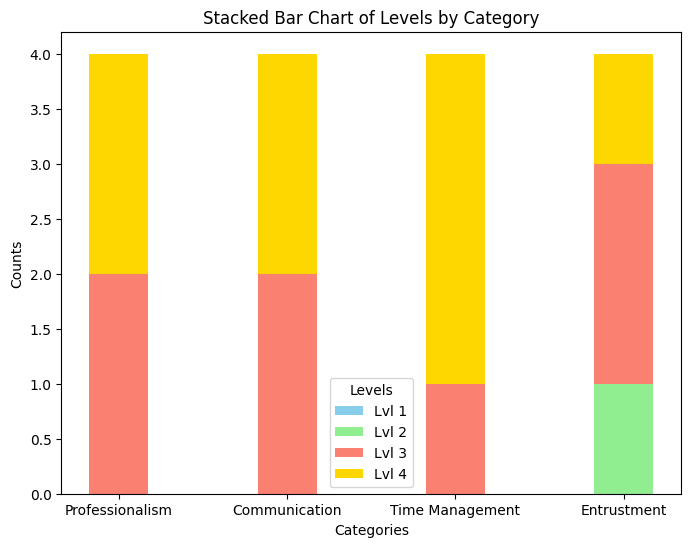

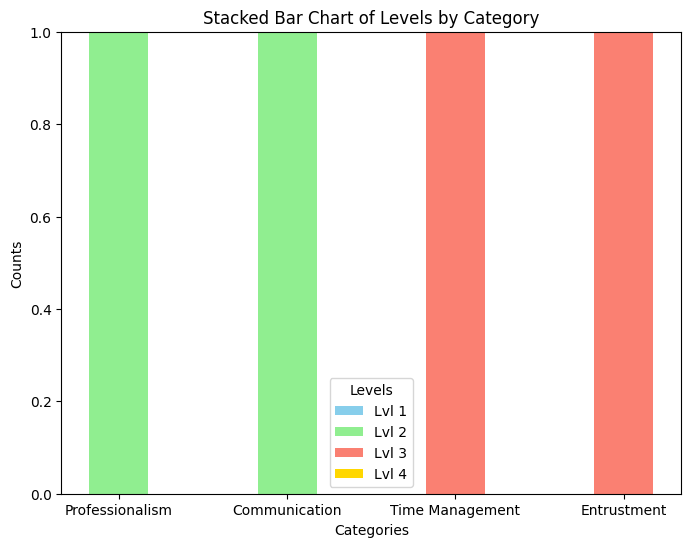

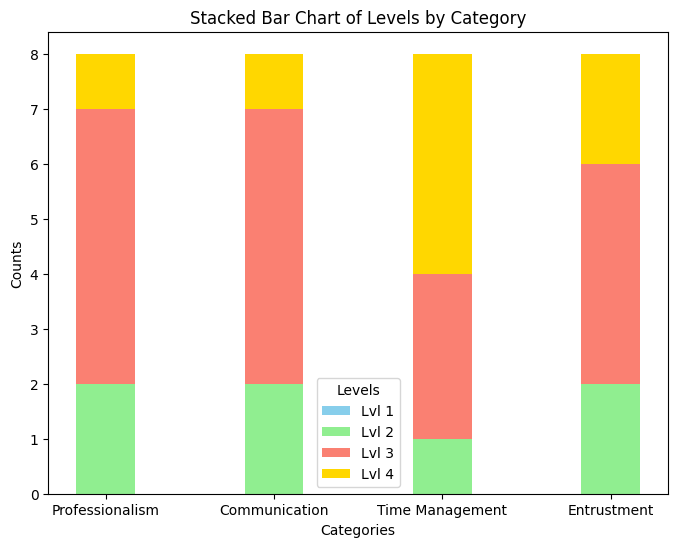

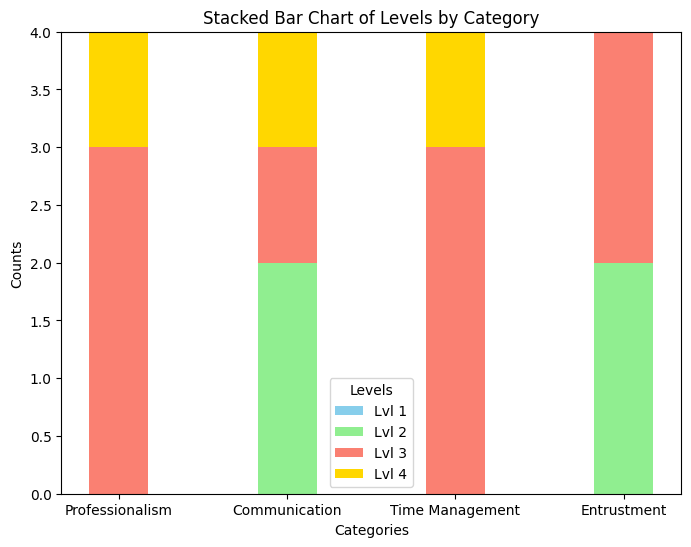

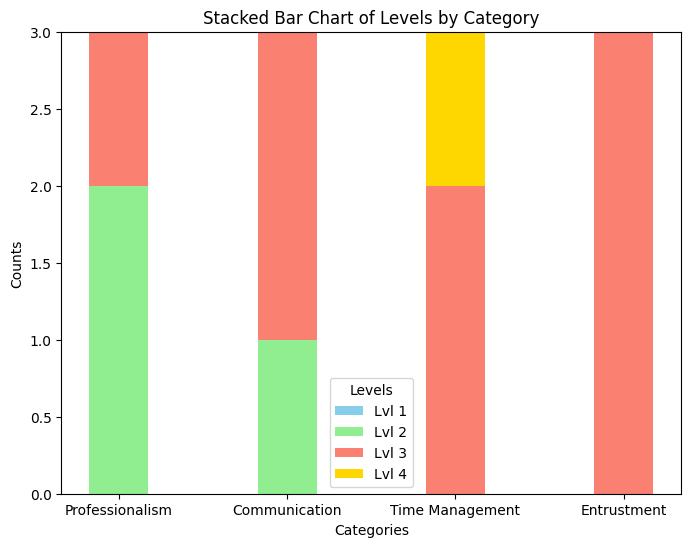

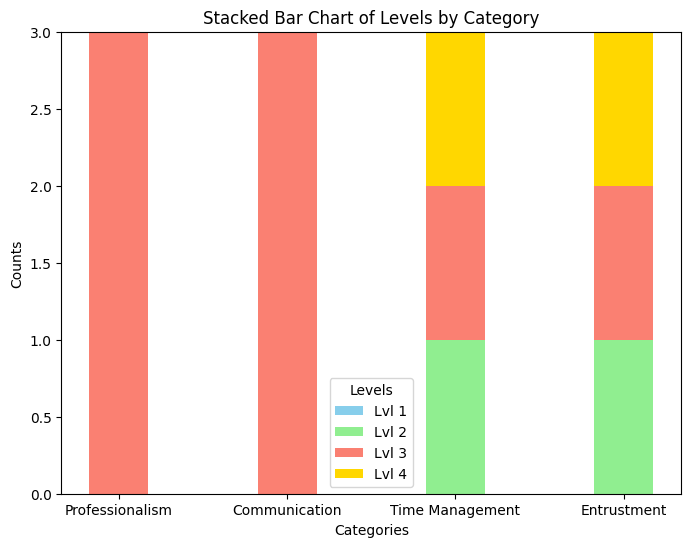

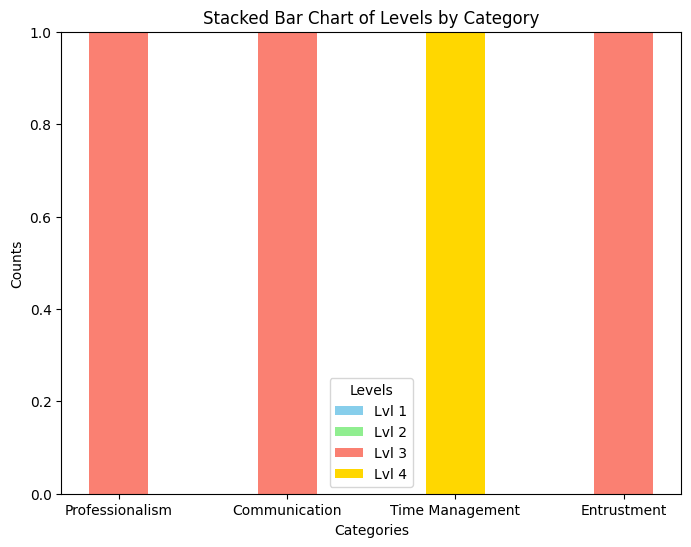

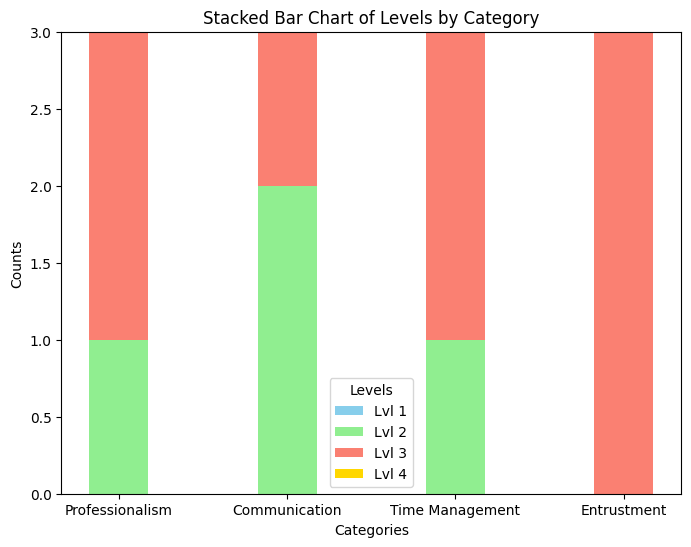

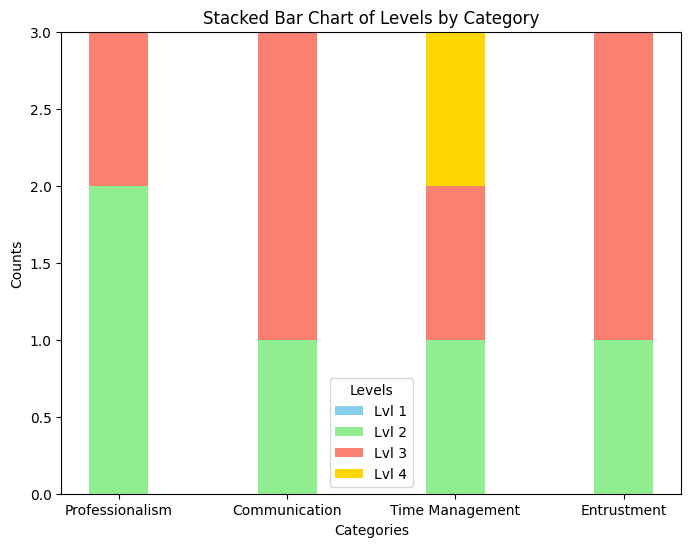

In [5]:

allPersons = oral30002df['FullName'].unique()
for person in allPersons:
    extractPersonInfo(person, oral30002df)

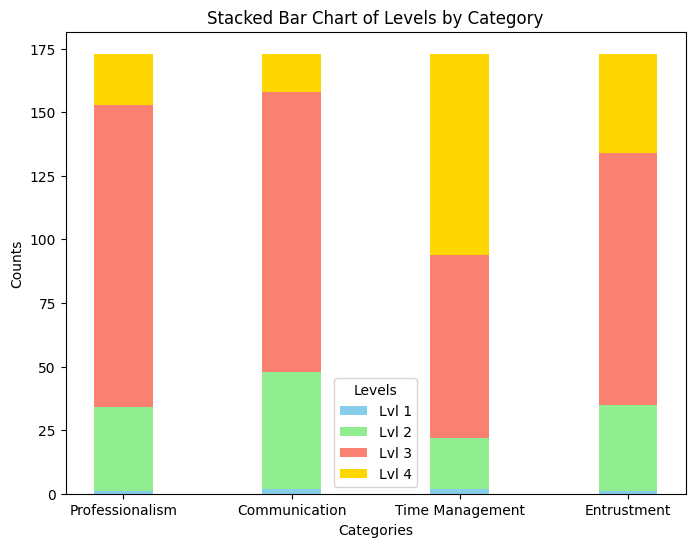

In [6]:
# Overall
plotGraphs('All', oral30002df)

Rows with level 1 values

In [59]:
# Extract names where Lvl 1 in communication scale or other categories
# professionalism
print('Professionalism: ', oral30002df[oral30002df['Q61'].str.contains('Lvl 1', na=False)][['FullName', 'Q2']].values)
# communication
print('Communication: ', oral30002df[oral30002df['Q62'].str.contains('Lvl 1', na=False)][['FullName', 'Q2']].values)
# time management
print('Time management: ', oral30002df[oral30002df['Q130'].str.contains('Lvl 1', na=False)][['FullName', 'Q2']].values)
# entrustment
print('Entrustment: ', oral30002df[oral30002df['Q63'].str.contains('Lvl 1', na=False)][['FullName', 'Q2']].values)

Professionalism:  [['Thuvasaki Mahinthan' '21 Mar 2024']]
Communication:  [['Xiaochuan Yang' '7 Mar 2024']
 ['Zephaniah Josephene' '8 Apr 2024']]
Time management:  [['Monique Huynh' '8 Feb 2024']
 ['Paloma Araos-West' '8 Apr 2024']]
Entrustment:  [['Xiaochuan Yang' '7 Mar 2024']]


### Rows with Lvl 2 

In [8]:
# Extract names where Lvl 2 in communication scale or other categories
# Professionalism
professionals = oral30002df[oral30002df['Q61'].str.contains('Lvl 2', na=False)]
print('1. Professionalism:')
for index, row in professionals.iterrows():
    print(f"- {row['FullName']} on {row['Q2']}")

# Communication
communicators = oral30002df[oral30002df['Q62'].str.contains('Lvl 2', na=False)]
print('\n2. Communication:')
for index, row in communicators.iterrows():
    print(f"- {row['FullName']} on {row['Q2']}")

# Time management
timeManagers = oral30002df[oral30002df['Q130'].str.contains('Lvl 2', na=False)]
print('\n3. Time management:')
for index, row in timeManagers.iterrows():
    print(f"- {row['FullName']} on {row['Q2']}")

# Entrustment
entrusted = oral30002df[oral30002df['Q63'].str.contains('Lvl 2', na=False)]
print('\n4. Entrustment:')
for index, row in entrusted.iterrows():
    print(f"- {row['FullName']} on {row['Q2']}")


1. Professionalism:
- Hannah Khodabakus on 5 Feb 2024
- Thuvasaki Mahinthan on 5 Feb 2024
- Nestor Del Carmen on 5 Feb 2024
- Hannah Khodabakus on 8 Feb 2024
- Thuvasaki Mahinthan on 8 Feb 2024
- Paloma Araos-West on 8 Feb 2024
- Paloma Araos-West on 8 Feb 2024
- Nestor Del Carmen on 15 Feb 2024
- Paloma Araos-West on 15 Feb 2024
- Hannah Khodabakus on 15 Feb 2024
- Hannah Khodabakus on 15 Feb 2024
- Paranee Chutipongpattanakul on 19 Feb 2024
- Yaanula Wanigasekera on 22 Feb 2024
- Fathima Zakiya Ahamed Zuhdi on 29 Feb 2024
- Sarah Qasem on 29 Feb 2024
- Xiaochuan Yang on 7 Mar 2024
- Aisha Ali-Nadif on 14 Mar 2024
- Fathima Zakiya Ahamed Zuhdi on 14 Mar 2024
- Aisha Ali-Nadif on 14 Mar 2024
- Thuvasaki Mahinthan on 21 Mar 2024
- Sarah Qasem on 21 Mar 2024
- Paloma Araos-West on 21 Mar 2024
- Zihan Wang on 21 Mar 2024
- Thuvasaki Mahinthan on 8 Apr 2024
- Zephaniah Josephene on 8 Apr 2024
- Zephaniah Josephene on 8 Apr 2024
- Paloma Araos-West on 8 Apr 2024
- Zephaniah Josephene on 8 A

If only unique names are desired

In [10]:
# Professionalism
professionals = oral30002df[oral30002df['Q61'].str.contains('Lvl 2', na=False)][['FullName', 'Q2']].drop_duplicates(subset=['FullName'])
print('1. Professionalism:')
for index, row in professionals.iterrows():
    print(f"- {row['FullName']}")

# Communication
communicators = oral30002df[oral30002df['Q62'].str.contains('Lvl 2', na=False)][['FullName', 'Q2']].drop_duplicates(subset=['FullName'])
print('\n2. Communication:')
for index, row in communicators.iterrows():
    print(f"- {row['FullName']}")

# Time management
timeManagers = oral30002df[oral30002df['Q130'].str.contains('Lvl 2', na=False)][['FullName', 'Q2']].drop_duplicates(subset=['FullName'])
print('\n3. Time management:')
for index, row in timeManagers.iterrows():
    print(f"- {row['FullName']}")

# Entrustment
entrusted = oral30002df[oral30002df['Q63'].str.contains('Lvl 2', na=False)][['FullName', 'Q2']].drop_duplicates(subset=['FullName'])
print('\n4. Entrustment:')
for index, row in entrusted.iterrows():
    print(f"- {row['FullName']}")


1. Professionalism:
- Hannah Khodabakus
- Thuvasaki Mahinthan
- Nestor Del Carmen
- Paloma Araos-West
- Paranee Chutipongpattanakul
- Yaanula Wanigasekera
- Fathima Zakiya Ahamed Zuhdi
- Sarah Qasem
- Xiaochuan Yang
- Aisha Ali-Nadif
- Zihan Wang
- Zephaniah Josephene
- Kristine Yako
- Catrina Le
- Jessica Fry

2. Communication:
- Hannah Khodabakus
- Thuvasaki Mahinthan
- Paloma Araos-West
- Nestor Del Carmen
- Paranee Chutipongpattanakul
- Monique Huynh
- Xiao TAN
- Uyen Phan
- Yaanula Wanigasekera
- Xiaochuan Yang
- Zihan Wang
- Fathima Zakiya Ahamed Zuhdi
- Costanza Conidi
- Anjeela Khaliq
- Aisha Ali-Nadif
- Zephaniah Josephene
- Kristine Yako
- Catrina Le
- Niri Musis
- Jessica Fry

3. Time management:
- Paloma Araos-West
- Paranee Chutipongpattanakul
- Xiaochuan Yang
- Zihan Wang
- Anjeela Khaliq
- Sarah Qasem
- Aisha Ali-Nadif
- Fathima Zakiya Ahamed Zuhdi
- Thuvasaki Mahinthan
- Zephaniah Josephene
- Lisa Thanh Thao Bui
- Kristine Yako
- Jessica Fry

4. Entrustment:
- Monique H

Markdown script for each student report

In [16]:
import os

# Directory containing the student report images
directoryPath = 'oral30002/studentReport'
imageDir = 'studentReport'
# List all files in the directory
fileNames = os.listdir(directoryPath)

# Start with an empty markdown string
markdownOutput = ""

# Loop through each file in the directory
for fileName in fileNames:

    if fileName.endswith('.png'):  # Check if the file is a PNG image
        studentName = fileName[:-4]  # Remove the '.png' to get the student's name
        imagePath = os.path.join(imageDir, fileName).replace(' ', '%20')
        markdownOutput += f"### {studentName}\n"
        markdownOutput += f"![{studentName}]({imagePath})\n\n"

# Print the complete markdown script
print(markdownOutput)


### Aisha Ali-Nadif
![Aisha Ali-Nadif](studentReport\Aisha%20Ali-Nadif.png)

### Anjeela Khaliq
![Anjeela Khaliq](studentReport\Anjeela%20Khaliq.png)

### Catrina Le
![Catrina Le](studentReport\Catrina%20Le.png)

### Costanza Conidi
![Costanza Conidi](studentReport\Costanza%20Conidi.png)

### Daniel Tran
![Daniel Tran](studentReport\Daniel%20Tran.png)

### Fathima Zakiya Ahamed Zuhdi
![Fathima Zakiya Ahamed Zuhdi](studentReport\Fathima%20Zakiya%20Ahamed%20Zuhdi.png)

### Hannah Khodabakus
![Hannah Khodabakus](studentReport\Hannah%20Khodabakus.png)

### Jessica Fry
![Jessica Fry](studentReport\Jessica%20Fry.png)

### Jessica Hodgkin
![Jessica Hodgkin](studentReport\Jessica%20Hodgkin.png)

### Kristine Yako
![Kristine Yako](studentReport\Kristine%20Yako.png)

### Liarna Ly
![Liarna Ly](studentReport\Liarna%20Ly.png)

### Lisa Thanh Thao Bui
![Lisa Thanh Thao Bui](studentReport\Lisa%20Thanh%20Thao%20Bui.png)

### MattFNAME WhiteLNAME
![MattFNAME WhiteLNAME](studentReport\MattFNAME%20White